# Лабораторная работа №4

Описание работы
Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                            davies_bouldin_score, pairwise_distances)
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.stats import shapiro
import warnings

warnings.filterwarnings("ignore")

Был выбран датасет покупателей торгового центра ([Mall Customer Segmentation Data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data)) - выделение групп покупателей по ежегодному доходу, возрасту и баллам лояльности.

In [26]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Дескриптивный анализ

Вовод статистики по каждому признаку

In [27]:
display(df.describe())
df.info()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Визуальная оценка распределения признаков выявила, что признаки не имеют нормального распределения

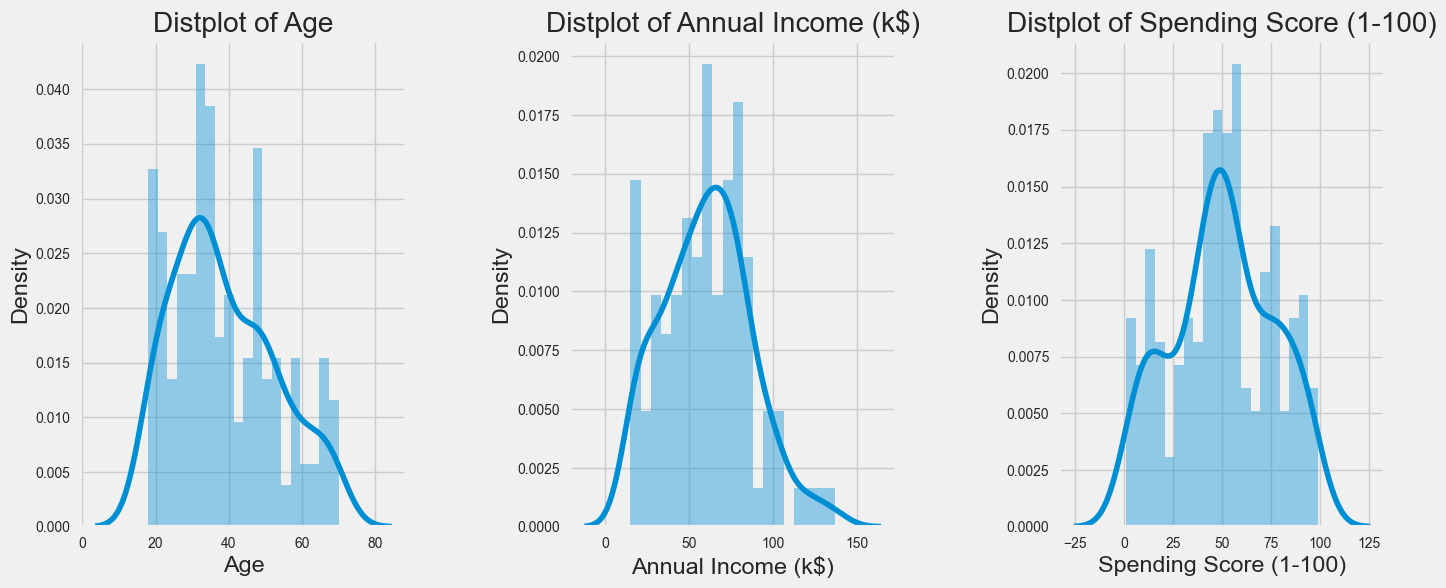

In [28]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

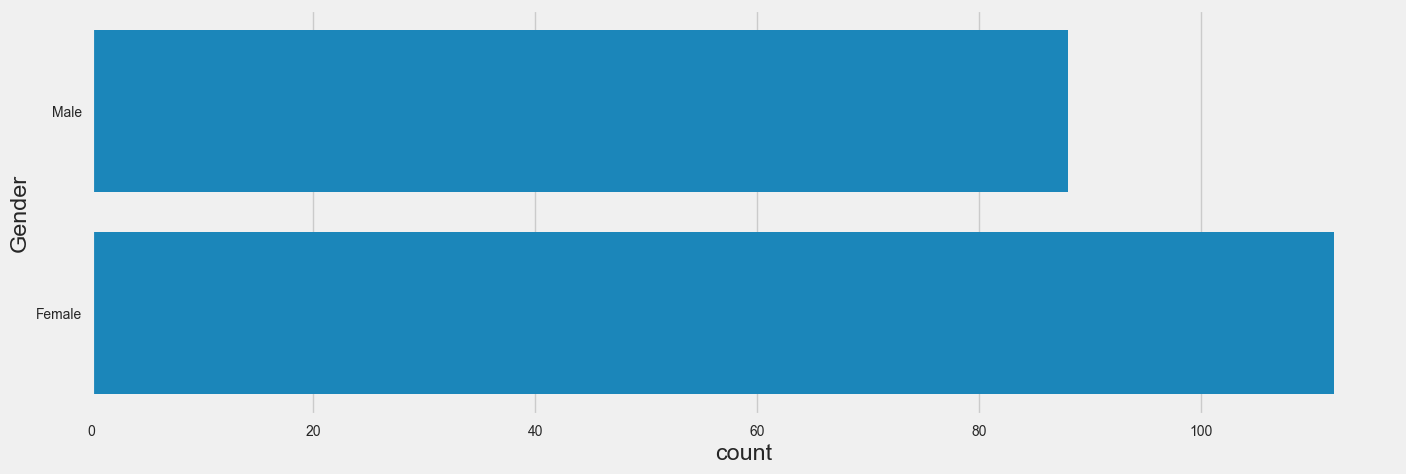

In [29]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df)
plt.show()

Сделаем анализ на количество пропущеных значений и на количество дубликатов, также вывдем размерность наших данных. Анализ показал, что наши данные не имеют пропусков и дубликатов.

In [ ]:
print("Пропуски в данных:")
print(df.isnull().sum())
print(f"\nВсего пропусков: {df.isnull().sum().sum()}")
print(f"\nДубликаты: {df.duplicated().sum()}")
print(f"\nРазмерность данных: {df.shape}")
print(f"Количество признаков: {df.shape[1]}")
print(f"Количество наблюдений: {df.shape[0]}")


Пропуски в данных:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Всего пропусков: 0

Дубликаты: 0

Размерность данных: (200, 5)
Количество признаков: 5
Количество наблюдений: 200


**Интерквартильный размах** представляет собой порядковую статистику, численно равную разности между 1-м и 3-м квартилями распределения или 25-м и 75-м процентилями. Можно так же сказать, что интерквартильный размах это половина выборки, центрированная относительно медианы.

Интерквартильный размах является удобным показателем изменчивости признака для асимметричных распределений или наборов данных с аномальными значениями. Иными словами его можно рассматривать в качестве аналога дисперсии, который является робастным к выбросам в данных.

Применяя IQR а также анализ BoxPlot было выявлено 2 выбраса, однако если проанализировать данные, то можно сказать, что данные выбросы, не являются выбросами и находтся в допустимых значениях. Следовательно, удолять мы их не будем.

Выбросы (метод IQR):
Age: 0 выбросов (0.00%)
Annual Income (k$): 2 выбросов (1.00%)
Spending Score (1-100): 0 выбросов (0.00%)


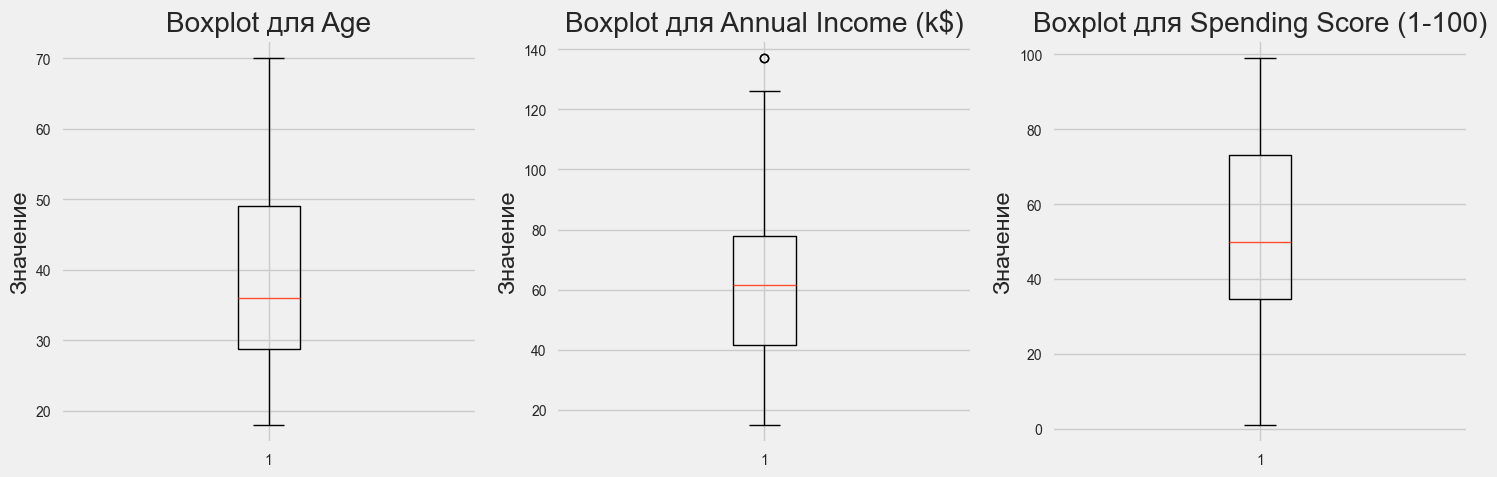

In [ ]:
from scipy import stats

numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

print("Выбросы (метод IQR):")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.2f}%)")

# Визуализация выбросов
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col])
    axes[idx].set_title(f'Boxplot для {col}')
    axes[idx].set_ylabel('Значение')
plt.tight_layout()
plt.show()


## Проверка условий применения кластеризации

1. **Отсутствие классов**: В данных нет предопределенных классов - это задача кластеризации
2. **Осмысленность кластеризации**: Кластеризация клиентов по возрасту, доходу и тратам имеет смысл для сегментации
3. **Выбросы**: Проверены выше, их количество незначительно


In [ ]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

from scipy.stats import shapiro

print("Тест нормальности распределения (Shapiro-Wilk):")
for i, col in enumerate(numeric_cols):
    stat, p_value = shapiro(df[col].sample(min(5000, len(df))))
    print(f"{col}: статистика={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print(f"  -> Распределение близко к нормальному")
    else:
        print(f"  -> Распределение НЕ нормальное")

Тест нормальности распределения (Shapiro-Wilk):
Age: статистика=0.9516, p-value=0.0000
  -> Распределение НЕ нормальное
Annual Income (k$): статистика=0.9784, p-value=0.0035
  -> Распределение НЕ нормальное
Spending Score (1-100): статистика=0.9695, p-value=0.0002
  -> Распределение НЕ нормальное


Также дополнительно проведенный тест Шапиро-Уилка подтвердил, что данные распределены не нормально.

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Для визуальной оценки количества класетров, проанализируем диаграмму рассеивания. Из признаков `Spending Score` и `Annual Income`, можно предположить, что **классов - 5**.

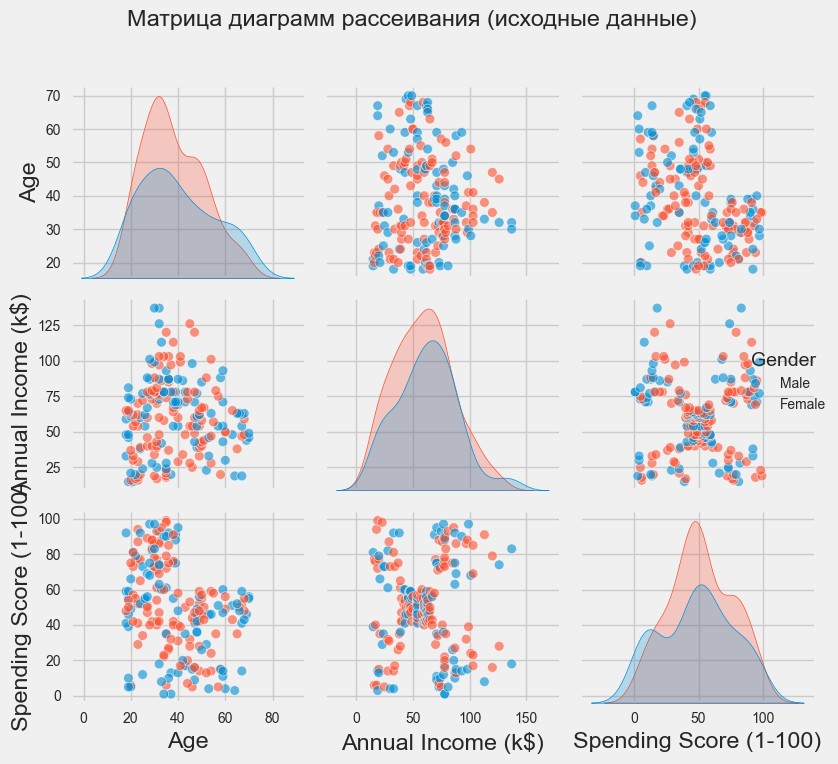

In [72]:

sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender']], 
             hue='Gender', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеивания (исходные данные)', y=1.02)
plt.tight_layout()
plt.show()


## Обоснование выбора методов кластеризации

**K-means:**
- Подходит для сферических кластеров примерно одинакового размера
- Требует задание числа кластеров k
- Быстрый и эффективный для больших данных

**DBSCAN:**
- Подходит для кластеров произвольной формы
- Не требует задание числа кластеров
- Может выделять выбросы как шум
- Хорошо работает с кластерами разной плотности


**Метод локтя (Elbow method)** — инструмент анализа данных, направленный на оптимизацию числа кластеров в алгоритмах кластеризации.
Правильно подобранное количество кластеров в алгоритмах позволяет найти баланс между погрешностью вычисляемой дисперсии и сложностью модели. Использование метода позволяет избежать недообучения или переобучения алгоритма кластеризации.
Метод применим к алгоритму k-средних и заключается в неоднократном повторении сценария. При использовании метода для каждого натурального числа 
k из некоторого диапазона строится значение целевой функции, равной сумме внутрикластерных расстояний. Количество кластеров — гиперпараметр, т.е. он будет определен перед запуском модели.

**Коэффициент «силуэт»** вычисляется с помощью среднего внутрикластерного расстояния (a) и среднего расстояния до ближайшего кластера (b) по каждому образцу. Силуэт вычисляется как (b - a) / max(a, b). Поясню: b — это расстояние между a и ближайшим кластером, в который a не входит. Можно вычислить среднее значение силуэта по всем образцам и использовать его как метрику для оценки количества кластеров.


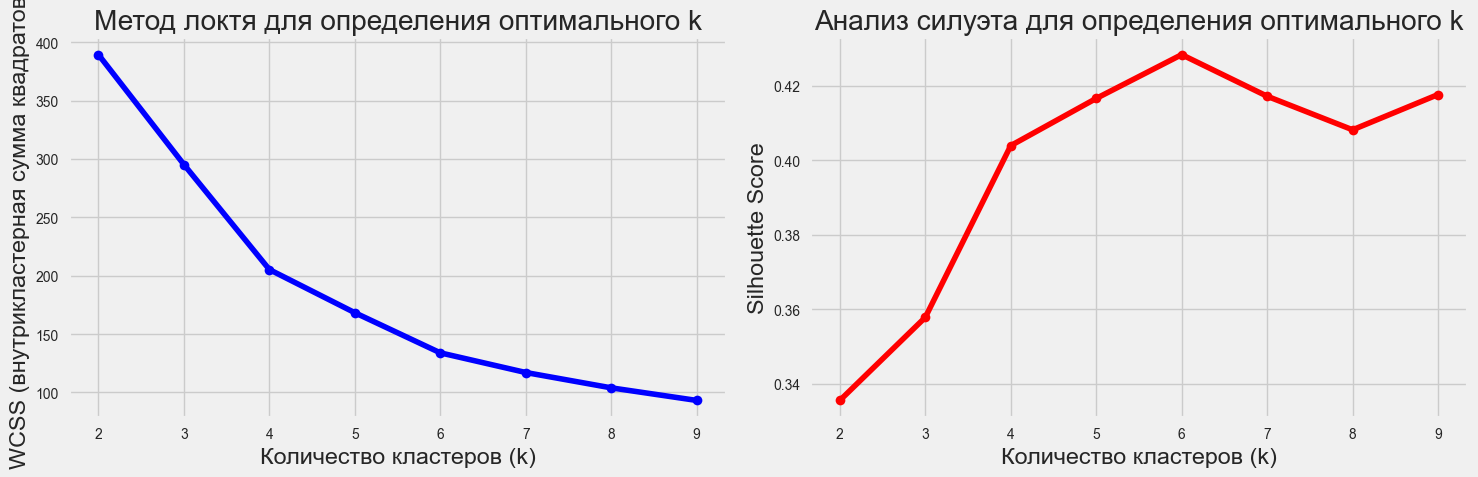

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('WCSS (внутрикластерная сумма квадратов)')
ax1.set_title('Метод локтя для определения оптимального k')
ax1.grid(True)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Анализ силуэта для определения оптимального k')
ax2.grid(True)

plt.tight_layout()
plt.show()
optimal_k = 6

На графике Метода локтя, можно предположить, что количество кластеров от 4 до 6, однако анализируя график силуэта, можно сказать, что кластеров - 6. Для дальнейшего посроения модели используем **6 кластеров**

In [75]:

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_centers = kmeans.cluster_centers_

print(f"K-means кластеризация с k={optimal_k}")
print(f"Центры кластеров:")
for i, center in enumerate(kmeans_centers):
    print(f"  Кластер {i}: {center}")

df['KMeans_Cluster'] = kmeans_labels


K-means кластеризация с k=6
Центры кластеров:
  Кластер 0: [ 1.25472096 -0.24021294 -0.04399777]
  Кластер 1: [-0.86515664 -0.13196835 -0.08043031]
  Кластер 2: [ 0.22171558  1.08322527 -1.29005223]
  Кластер 3: [-0.44191719  0.99158305  1.23950275]
  Кластер 4: [-0.99396865 -1.34734766  1.06404834]
  Кластер 5: [ 0.47895722 -1.30822992 -1.19644353]


Существуют эвристики для выбора $m$ и $\epsilon$. Чаще всего применяется такой метод и его вариации:

Выберите $m$. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять $m$.
Вычислите среднее расстояние по $m$ ближайшим соседям для каждой точки. Т.е. если $m=3$, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.
Сортируем полученные значения по возрастанию и выводим на экран.
Видим что-то вроде такого резко возрастающего графика. Следует взять $\epsilon$ где-нибудь в полосе, где происходит самый сильный перегиб. Чем больше $\epsilon$, тем больше получатся кластеры, и тем меньше их будет.

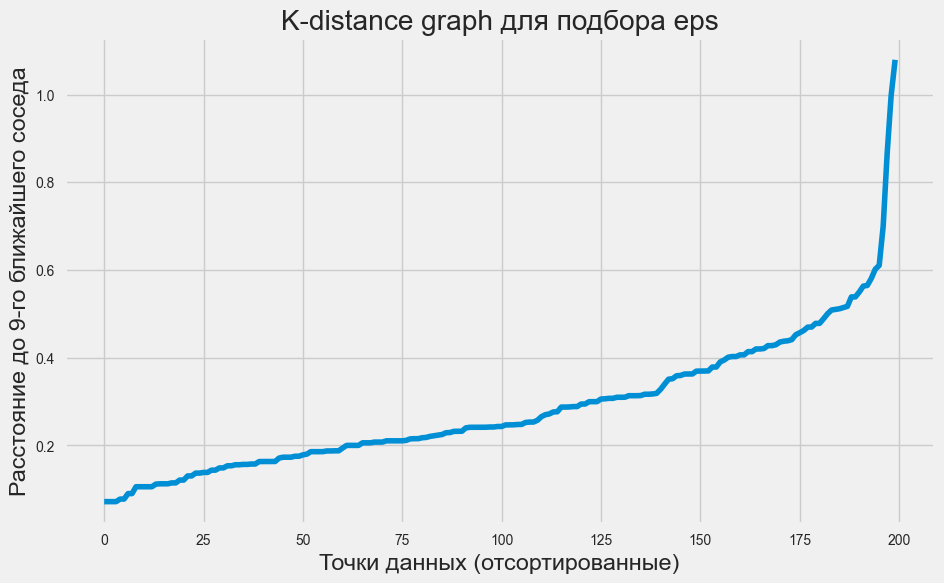

Подбор параметров DBSCAN:
  eps=0.3, min_samples=3: 12 кластеров, 103 шум, silhouette=-0.0796
  eps=0.3, min_samples=4: 7 кластеров, 121 шум, silhouette=-0.0796
  eps=0.3, min_samples=5: 10 кластеров, 134 шум, silhouette=-0.1822
  eps=0.4, min_samples=3: 10 кластеров, 59 шум, silhouette=0.1513
  eps=0.4, min_samples=4: 8 кластеров, 73 шум, silhouette=0.1131
  eps=0.4, min_samples=5: 6 кластеров, 98 шум, silhouette=0.0760
  eps=0.5, min_samples=3: 8 кластеров, 32 шум, silhouette=0.1316
  eps=0.5, min_samples=4: 8 кластеров, 39 шум, silhouette=0.1122
  eps=0.5, min_samples=5: 6 кластеров, 60 шум, silhouette=0.1845
  eps=0.6, min_samples=3: 3 кластеров, 14 шум, silhouette=0.1779
  eps=0.6, min_samples=4: 3 кластеров, 18 шум, silhouette=0.1553
  eps=0.6, min_samples=5: 2 кластеров, 28 шум, silhouette=0.1880
  eps=0.7, min_samples=3: 2 кластеров, 7 шум, silhouette=0.1393
  eps=0.7, min_samples=4: 2 кластеров, 9 шум, silhouette=0.1446
  eps=0.7, min_samples=5: 1 кластеров, 14 шум (недостаточ

In [62]:
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=9)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Точки данных (отсортированные)')
plt.ylabel('Расстояние до 9-го ближайшего соседа')
plt.title('K-distance graph для подбора eps')
plt.grid(True)
plt.show()

eps_candidates = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_candidates = [3, 4, 5]

best_eps = None
best_min_samples = None
best_silhouette = -1
best_labels = None

print("Подбор параметров DBSCAN:")
for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            silhouette = silhouette_score(X_scaled, labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
            print(f"  eps={eps}, min_samples={min_samples}: {n_clusters} кластеров, {n_noise} шум, silhouette={silhouette:.4f}")
        else:
            print(f"  eps={eps}, min_samples={min_samples}: {n_clusters} кластеров, {n_noise} шум (недостаточно кластеров)")



dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN кластеризация завершена:")
print(f"  Количество кластеров: {n_clusters_dbscan}")
print(f"  Количество шумовых точек: {n_noise} ({n_noise/len(X_scaled)*100:.2f}%)")

df['DBSCAN_Cluster'] = dbscan_labels

Будем считать, что перегиб находится в районе $\epsilon$ = 0.5 и `min sample` = 5

- Silhouette Score (Силуэтный коэффициент): Отражает степень схожести объектов внутри кластеров по сравнению с другими кластерами. Для каждого объекта рассчитывается, насколько он близок к своим соседям по кластеру (a) и насколько далек от объектов ближайшего соседнего кластера (b). Силуэтный коэффициент вычисляется как (b - a) / max(a, b) и усредняется по всем объектам.

    Диапазон: от -1 до 1.

    Интерпретация: Чем ближе значение к 1, тем лучше. Значения около 0 указывают на перекрывающиеся кластеры. Отрицательные значения говорят о возможной ошибочной кластеризации (объекты могли быть назначены не тому кластеру).

- Calinski-Harabasz Index (Индекс Калинского-Харабаса): Также известен как индекс дисперсионного отношения. Измеряет отношение суммы дисперсий между кластерами к сумме дисперсий внутри кластеров, с поправкой на количество кластеров и объектов.

    Диапазон: Не ограничен сверху (чем выше, тем лучше).

    Интерпретация: Чем выше значение, тем более плотными и хорошо разделенными являются кластеры. Высокое значение указывает на четкую кластерную структуру данных.

- Davies-Bouldin Index (Индекс Дэвиса-Болдайна): Оценивает среднее «сходство» между каждым кластером и его наиболее похожим кластером. «Сходство» определяется как отношение суммы средних внутрикластерных расстояний двух кластеров к расстоянию между их центрами.

    Диапазон: От 0 и выше.

    Интерпретация: Чем ближе значение к 0, тем лучше. Низкий индекс означает, что кластеры плотные и далеко отстоят друг от друга.

In [76]:
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                            davies_bouldin_score, pairwise_distances)

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\nВнутренние метрики:")
print(f"  Silhouette Score: {kmeans_silhouette:.4f} (чем выше, тем лучше, диапазон [-1, 1])")
print(f"  Calinski-Harabasz Index: {kmeans_calinski:.4f} (чем выше, тем лучше)")
print(f"  Davies-Bouldin Index: {kmeans_davies:.4f} (чем ниже, тем лучше)")

intra_cluster_distances = []
for i in range(optimal_k):
    cluster_points = X_scaled[kmeans_labels == i]
    if len(cluster_points) > 1:
        distances = pairwise_distances(cluster_points)
        upper_triangle = distances[np.triu_indices(len(distances), k=1)]
        intra_cluster_distances.append(np.mean(upper_triangle))
        print(f"\n  Кластер {i}:")
        print(f"    Размер: {len(cluster_points)} точек")
        print(f"    Среднее внутрикластерное расстояние: {np.mean(upper_triangle):.4f}")

# Межкластерные расстояния
inter_cluster_distances = pairwise_distances(kmeans_centers)
print(f"\nМежкластерные расстояния (между центрами):")
for i in range(optimal_k):
    for j in range(i+1, optimal_k):
        print(f"  Кластер {i} <-> Кластер {j}: {inter_cluster_distances[i, j]:.4f}")

print(f"\nКомпактность кластеров (среднее расстояние до центра):")
for i in range(optimal_k):
    cluster_points = X_scaled[kmeans_labels == i]
    distances_to_center = np.linalg.norm(cluster_points - kmeans_centers[i], axis=1)
    compactness = np.mean(distances_to_center)
    print(f"  Кластер {i}: {compactness:.4f}")



Внутренние метрики:
  Silhouette Score: 0.4284 (чем выше, тем лучше, диапазон [-1, 1])
  Calinski-Harabasz Index: 135.1021 (чем выше, тем лучше)
  Davies-Bouldin Index: 0.8254 (чем ниже, тем лучше)

  Кластер 0:
    Размер: 45 точек
    Среднее внутрикластерное расстояние: 0.9517

  Кластер 1:
    Размер: 39 точек
    Среднее внутрикластерное расстояние: 0.9611

  Кластер 2:
    Размер: 33 точек
    Среднее внутрикластерное расстояние: 1.3445

  Кластер 3:
    Размер: 39 точек
    Среднее внутрикластерное расстояние: 0.9672

  Кластер 4:
    Размер: 23 точек
    Среднее внутрикластерное расстояние: 0.8964

  Кластер 5:
    Размер: 21 точек
    Среднее внутрикластерное расстояние: 1.2942

Межкластерные расстояния (между центрами):
  Кластер 0 <-> Кластер 1: 2.1230
  Кластер 0 <-> Кластер 2: 2.0908
  Кластер 0 <-> Кластер 3: 2.4583
  Кластер 0 <-> Кластер 4: 2.7405
  Кластер 0 <-> Кластер 5: 1.7523
  Кластер 1 <-> Кластер 2: 2.0301
  Кластер 1 <-> Кластер 3: 1.7843
  Кластер 1 <-> Класт

**Silhouette Score** = 0.4284 указывает на положительную, но не идеальную структуру. Значение заметно выше нуля, что подтверждает наличие кластеров, но далеко от 1, что может говорить о некоторой перекрытости или неидеальной плотности.

**Calinski-Harabasz Index**= 135.10 является достаточно высоким, что свидетельствует о хорошем соотношении межкластерной дисперсии к внутрикластерной. Это подтверждает, что кластеры различимы.

**Davies-Bouldin Index** = 0.8254 имеет низкое значение (близко к 0), что означает хорошую разделимость кластеров и их внутреннюю компактность.

**Вывод**: Все три метрики согласуются между собой, указывая на то, что алгоритм успешно выделил в данных отдельные, относительно плотные и различимые группы.

In [64]:
dbscan_silhouette = np.nan
dbscan_calinski = np.nan
dbscan_davies = np.nan

if n_clusters_dbscan > 1:

    non_noise_mask = dbscan_labels != -1
    X_non_noise = X_scaled[non_noise_mask]
    labels_non_noise = dbscan_labels[non_noise_mask]
    
    dbscan_silhouette = silhouette_score(X_non_noise, labels_non_noise)
    dbscan_calinski = calinski_harabasz_score(X_non_noise, labels_non_noise)
    dbscan_davies = davies_bouldin_score(X_non_noise, labels_non_noise)
    
    print(f"\nВнутренние метрики (без шумовых точек):")
    print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"  Calinski-Harabasz Index: {dbscan_calinski:.4f}")
    print(f"  Davies-Bouldin Index: {dbscan_davies:.4f}")

    print(f"\nВнутрикластерные расстояния:")
    for i in set(labels_non_noise):
        cluster_points = X_non_noise[labels_non_noise == i]
        if len(cluster_points) > 1:
            distances = pairwise_distances(cluster_points)
            upper_triangle = distances[np.triu_indices(len(distances), k=1)]
            print(f"  Кластер {i}:")
            print(f"    Размер: {len(cluster_points)} точек")
            print(f"    Среднее внутрикластерное расстояние: {np.mean(upper_triangle):.4f}")
            
    print(f"\nЦентры кластеров DBSCAN (средние значения, в исходном пространстве):")
    for i in set(labels_non_noise):
        cluster_points_original = X[dbscan_labels == i]
        center = np.mean(cluster_points_original, axis=0)
        print(f"  Кластер {i}: Age={center[0]:.1f}, Income={center[1]:.1f}, Spending={center[2]:.1f}")
    
    print(f"\nШумовые точки: {n_noise} ({n_noise/len(X_scaled)*100:.2f}%)")
else:
    print("Недостаточно кластеров для расчета метрик")



Внутренние метрики (без шумовых точек):
  Silhouette Score: 0.4817
  Calinski-Harabasz Index: 117.8049
  Davies-Bouldin Index: 0.6386

Внутрикластерные расстояния:
  Кластер 0:
    Размер: 17 точек
    Среднее внутрикластерное расстояние: 0.6449
  Кластер 1:
    Размер: 5 точек
    Среднее внутрикластерное расстояние: 0.5474
  Кластер 2:
    Размер: 51 точек
    Среднее внутрикластерное расстояние: 1.0461
  Кластер 3:
    Размер: 28 точек
    Среднее внутрикластерное расстояние: 0.7411
  Кластер 4:
    Размер: 32 точек
    Среднее внутрикластерное расстояние: 0.7432
  Кластер 5:
    Размер: 7 точек
    Среднее внутрикластерное расстояние: 0.4679

Центры кластеров DBSCAN (средние значения, в исходном пространстве):
  Кластер 0: Age=23.8, Income=25.8, Spending=78.2
  Кластер 1: Age=38.2, Income=27.8, Spending=31.8
  Кластер 2: Age=53.7, Income=54.2, Spending=48.4
  Кластер 3: Age=24.1, Income=54.3, Spending=50.5
  Кластер 4: Age=32.8, Income=80.9, Spending=83.6
  Кластер 5: Age=43.9, In

**Главный вывод:** Удаление 30% данных как шума (DBSCAN) привело к формированию значительно более качественной, четкой и интерпретируемой кластерной структуры по сравнению с предыдущим разбиением.

*Улучшение метрик*:

**Silhouette Score**: Вырос с 0.4284 до 0.4817. Это существенное улучшение, указывающее на возросшую «уверенность» алгоритма в принадлежности точек своим кластерам.

**Davies-Bouldin Index**: Снизился с 0.8254 до 0.6386. Это ключевое улучшение, подтверждающее, что кластеры стали более компактными и лучше отделены друг от друга.

**Calinski-Harabasz Index**: Незначительно снизился (со 135.10 до 117.80), что является ожидаемым при удалении значительной доли данных и изменении количества кластеров. Метрика по-прежнему остается на высоком уровне, подтверждая хорошую разделимость.


1. Влияние k на качество K-means:
 k  silhouette   calinski   davies    inertia
 2    0.335472 107.095567 1.260682 389.386189
 3    0.357793 101.694947 1.050270 295.212246
 4    0.403958 125.676397 0.930796 205.225147
 5    0.416643 125.100940 0.874551 168.247580
 6    0.428417 135.102104 0.825354 133.868421
 7    0.417232 132.774309 0.793467 117.011555
 8    0.408207 131.006216 0.891783 103.873292
 9    0.417693 130.003560 0.819844  93.092891
10    0.406554 132.638273 0.867904  82.385154


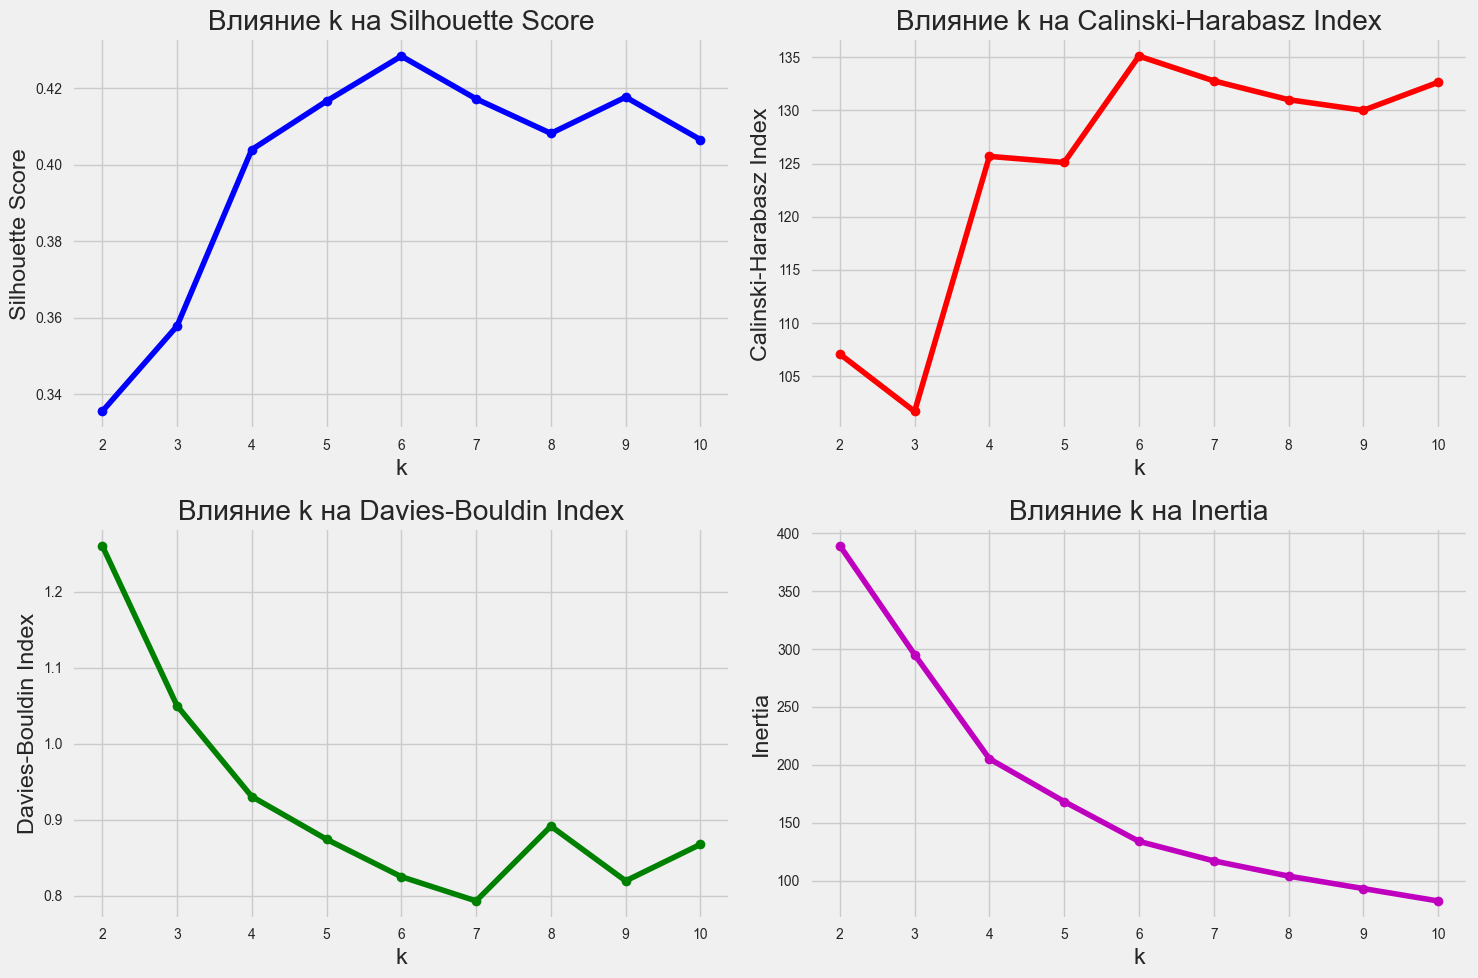

In [65]:
print("\n1. Влияние k на качество K-means:")
k_range_detailed = range(2, 11)
k_metrics = {'k': [], 'silhouette': [], 'calinski': [], 'davies': [], 'inertia': []}

for k in k_range_detailed:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_test = kmeans_test.fit_predict(X_scaled)
    
    k_metrics['k'].append(k)
    k_metrics['silhouette'].append(silhouette_score(X_scaled, labels_test))
    k_metrics['calinski'].append(calinski_harabasz_score(X_scaled, labels_test))
    k_metrics['davies'].append(davies_bouldin_score(X_scaled, labels_test))
    k_metrics['inertia'].append(kmeans_test.inertia_)

k_metrics_df = pd.DataFrame(k_metrics)
print(k_metrics_df.to_string(index=False))

# Визуализация влияния k
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].plot(k_metrics_df['k'], k_metrics_df['silhouette'], 'bo-')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Влияние k на Silhouette Score')
axes[0, 0].grid(True)

axes[0, 1].plot(k_metrics_df['k'], k_metrics_df['calinski'], 'ro-')
axes[0, 1].set_xlabel('k')
axes[0, 1].set_ylabel('Calinski-Harabasz Index')
axes[0, 1].set_title('Влияние k на Calinski-Harabasz Index')
axes[0, 1].grid(True)

axes[1, 0].plot(k_metrics_df['k'], k_metrics_df['davies'], 'go-')
axes[1, 0].set_xlabel('k')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Влияние k на Davies-Bouldin Index')
axes[1, 0].grid(True)

axes[1, 1].plot(k_metrics_df['k'], k_metrics_df['inertia'], 'mo-')
axes[1, 1].set_xlabel('k')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('Влияние k на Inertia')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()



2. Влияние параметров на качество DBSCAN:
 eps  min_samples  n_clusters  n_noise  silhouette   calinski   davies
 0.3            3          12      103    0.464513 125.775051 0.737595
 0.3            4           7      121    0.496808 182.403157 0.818168
 0.3            5          10      134    0.514353 279.008509 0.656899
 0.3            6           5      164    0.671171 299.834680 0.471680
 0.4            3          10       59    0.442575 119.612981 0.695576
 0.4            4           8       73    0.458460 139.066481 0.843541
 0.4            5           6       98    0.519023 175.360072 0.779564
 0.4            6           6      110    0.558444 210.649138 0.709457
 0.5            3           8       32    0.272562  36.361727 0.818961
 0.5            4           8       39    0.281527  35.191422 0.891758
 0.5            5           6       60    0.481715 117.804913 0.638575
 0.5            6           5       66    0.527767 144.378751 0.604342
 0.6            3           3     

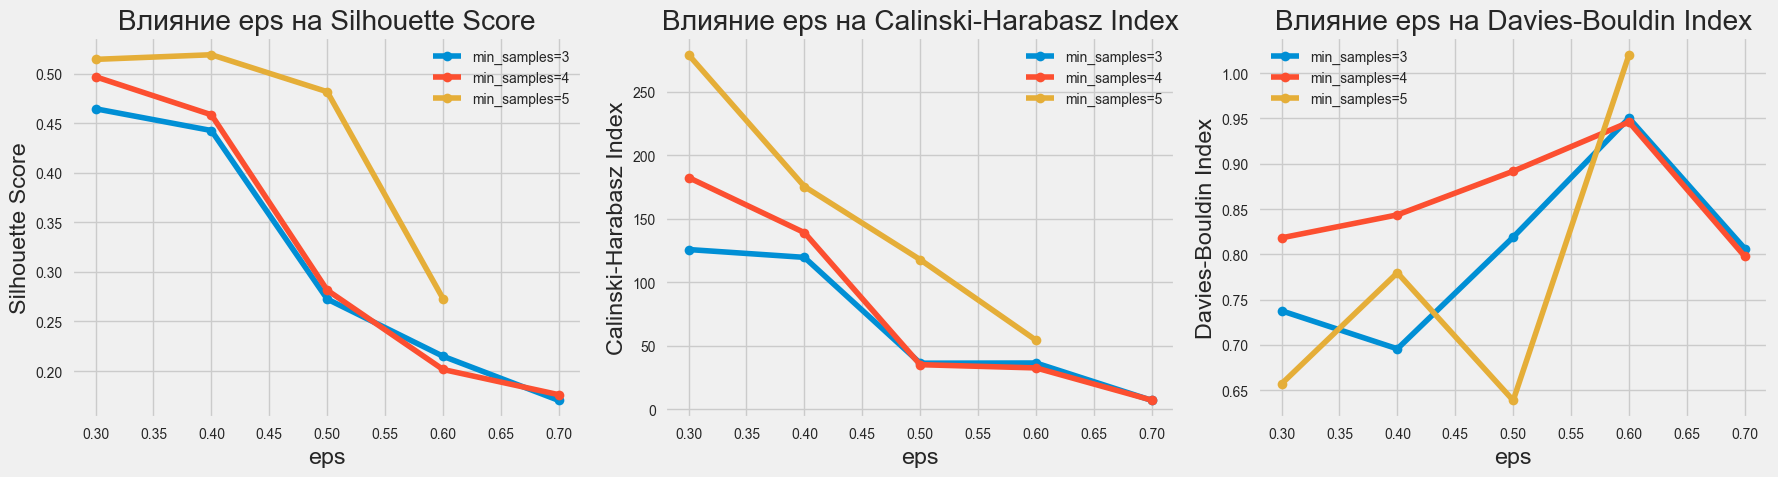

In [66]:
print("\n2. Влияние параметров на качество DBSCAN:")

eps_range = np.arange(0.3, 0.8, 0.1)
min_samples_range = [3, 4, 5, 6]

dbscan_results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan_test = DBSCAN(eps=eps, min_samples=min_samples)
        labels_test = dbscan_test.fit_predict(X_scaled)
        n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise = list(labels_test).count(-1)
        
        if n_clusters > 1:
            non_noise_mask = labels_test != -1
            X_non_noise = X_scaled[non_noise_mask]
            labels_non_noise = labels_test[non_noise_mask]
            silhouette = silhouette_score(X_non_noise, labels_non_noise)
            calinski = calinski_harabasz_score(X_non_noise, labels_non_noise)
            davies = davies_bouldin_score(X_non_noise, labels_non_noise)
        else:
            silhouette = -1
            calinski = 0
            davies = float('inf')
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies
        })

dbscan_results_df = pd.DataFrame(dbscan_results)
print(dbscan_results_df.to_string(index=False))

# Визуализация влияния eps при фиксированном min_samples
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for min_samples in [3, 4, 5]:
    subset = dbscan_results_df[dbscan_results_df['min_samples'] == min_samples]
    subset = subset[subset['n_clusters'] > 1]  # Только валидные результаты
    
    if len(subset) > 0:
        axes[0].plot(subset['eps'], subset['silhouette'], 'o-', label=f'min_samples={min_samples}')
        axes[1].plot(subset['eps'], subset['calinski'], 'o-', label=f'min_samples={min_samples}')
        axes[2].plot(subset['eps'], subset['davies'], 'o-', label=f'min_samples={min_samples}')

axes[0].set_xlabel('eps')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Влияние eps на Silhouette Score')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('eps')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Влияние eps на Calinski-Harabasz Index')
axes[1].legend()
axes[1].grid(True)

axes[2].set_xlabel('eps')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Влияние eps на Davies-Bouldin Index')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


PCA компоненты:
Объясненная дисперсия: [0.44266167 0.33308378]
Суммарная объясненная дисперсия: 0.7757


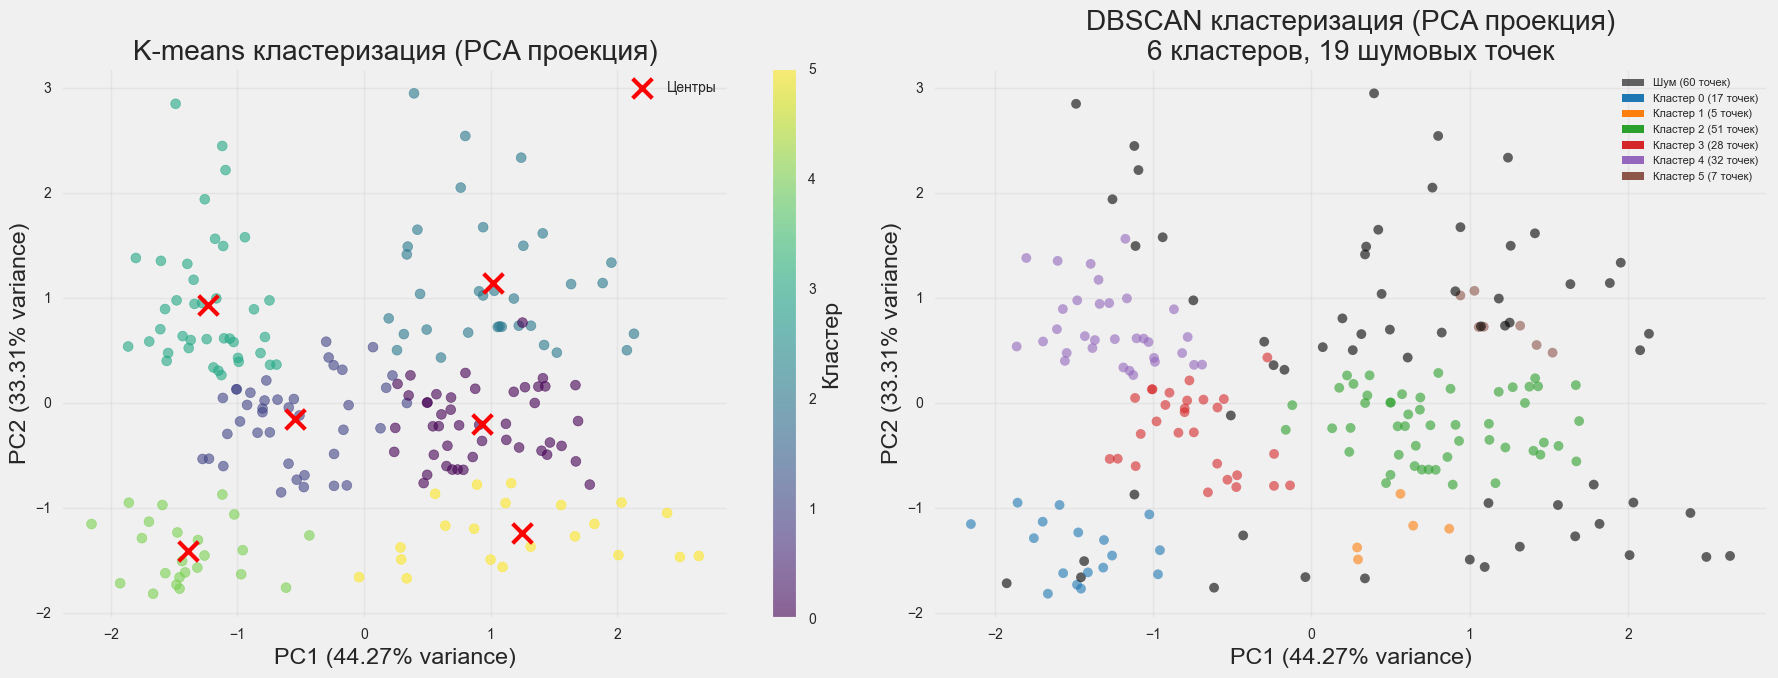

In [79]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA компоненты:")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
print(f"Суммарная объясненная дисперсия: {sum(pca.explained_variance_ratio_):.4f}")

unique_labels = np.unique(dbscan_labels)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, s=50)
centers_pca = pca.transform(kmeans_centers)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Центры')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('K-means кластеризация (PCA проекция)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

n_clusters_actual = len(unique_labels) - (1 if -1 in unique_labels else 0)

if n_clusters_actual <= 10:
    colors_list = plt.cm.tab10(np.linspace(0, 1, 10))
else:
    colors_list = plt.cm.tab20(np.linspace(0, 1, 20))

point_colors = []
for label in dbscan_labels:
    if label == -1:
        point_colors.append([0, 0, 0, 0.6])
    else:

        color_idx = label % len(colors_list)
        color = list(colors_list[color_idx])
        color[3] = 0.6  
        point_colors.append(color)

point_colors = np.array(point_colors)

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=point_colors, s=50, edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'DBSCAN кластеризация (PCA проекция)\n{n_clusters_dbscan} кластеров, {n_noise} шумовых точек')
axes[1].grid(True, alpha=0.3)

legend_elements = []
for label in sorted(unique_labels):
    count = np.sum(dbscan_labels == label)
    if label == -1:
        legend_elements.append(Patch(facecolor=[0, 0, 0, 0.6], label=f'Шум ({count} точек)'))
    else:
        color_idx = label % len(colors_list)
        legend_elements.append(Patch(facecolor=colors_list[color_idx], 
                                     label=f'Кластер {label} ({count} точек)'))
axes[1].legend(handles=legend_elements, loc='best', fontsize=8)

plt.tight_layout()
plt.show()


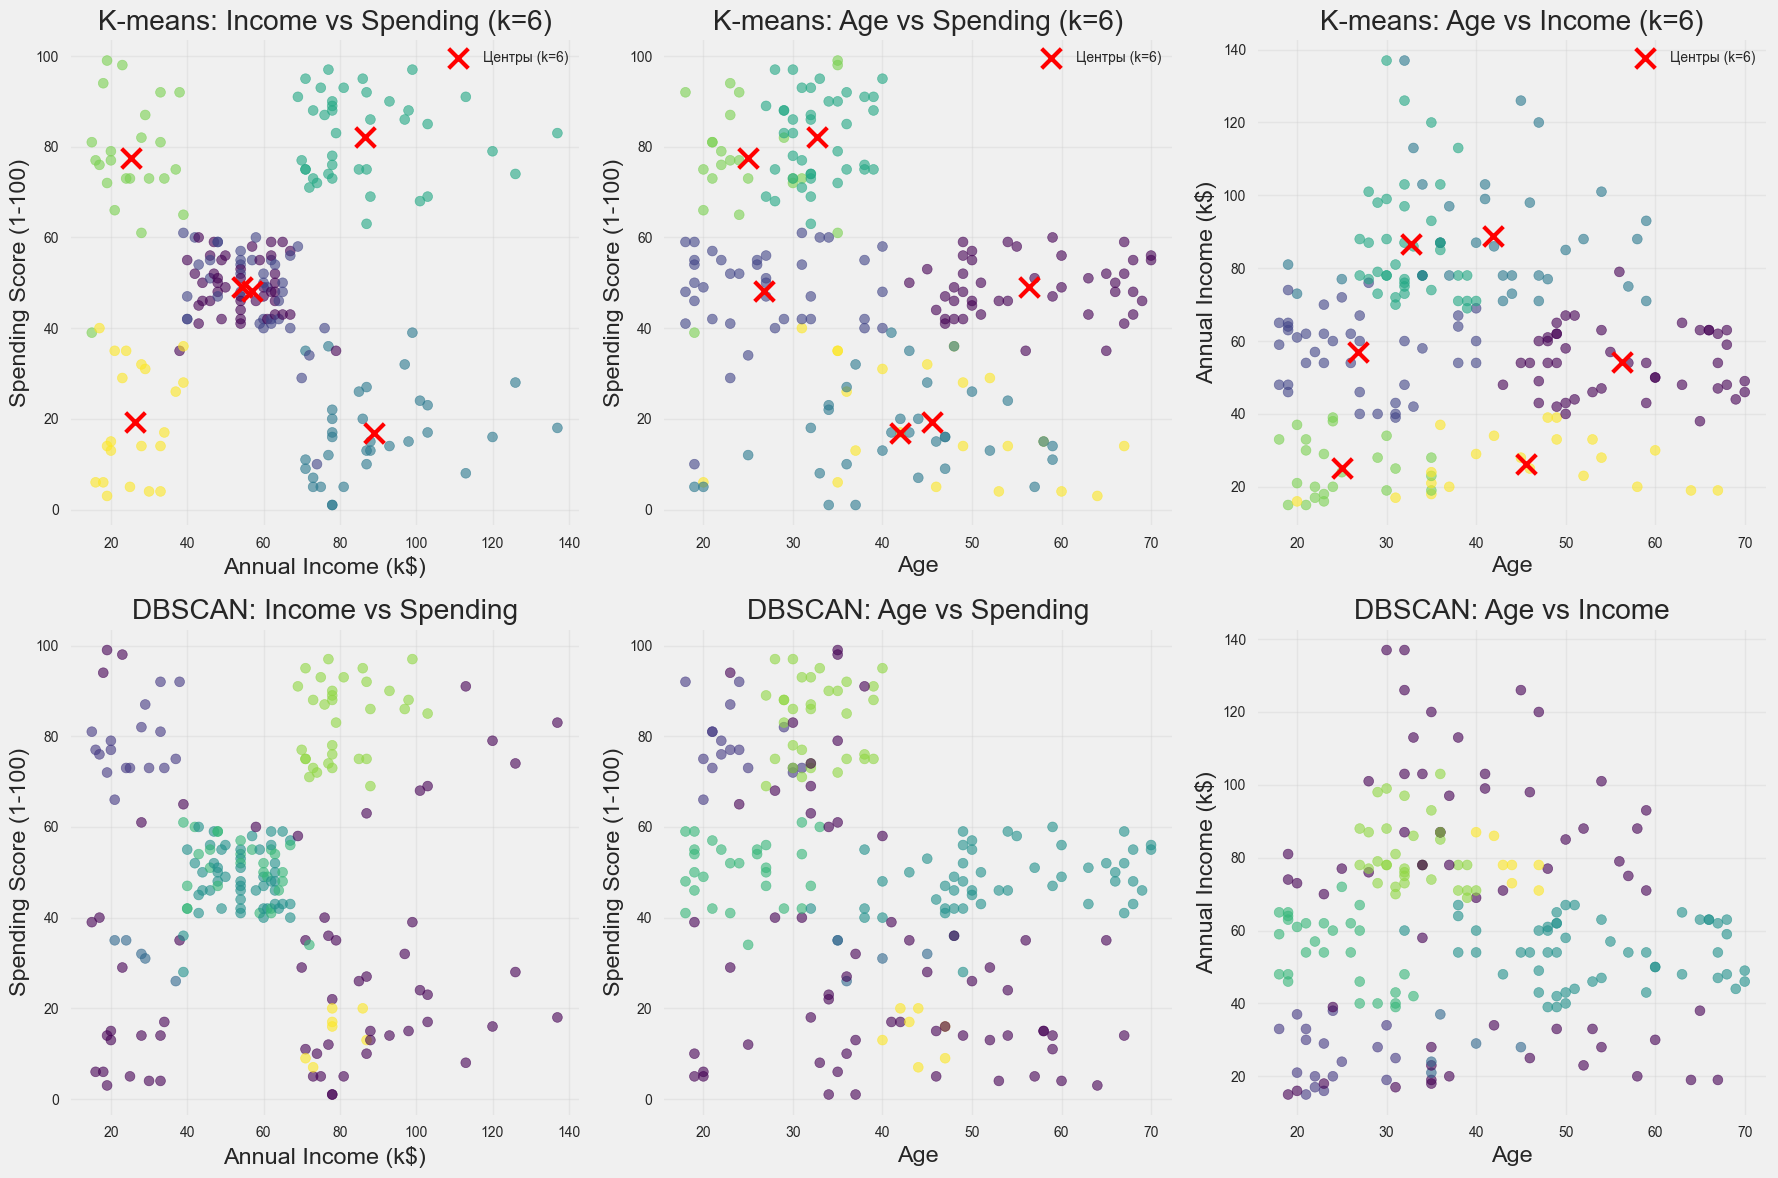

In [80]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

scatter1 = axes[0, 0].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                              c=kmeans_labels, cmap='viridis', alpha=0.6, s=50)
centers_orig = scaler.inverse_transform(kmeans_centers)
axes[0, 0].scatter(centers_orig[:, 1], centers_orig[:, 2], c='red', marker='x', 
                   s=200, linewidths=3, label=f'Центры (k={len(kmeans_centers)})')
axes[0, 0].set_xlabel('Annual Income (k$)')
axes[0, 0].set_ylabel('Spending Score (1-100)')
axes[0, 0].set_title(f'K-means: Income vs Spending (k={len(kmeans_centers)})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(df['Age'], df['Spending Score (1-100)'], 
                   c=kmeans_labels, cmap='viridis', alpha=0.6, s=50)
axes[0, 1].scatter(centers_orig[:, 0], centers_orig[:, 2], c='red', marker='x', 
                   s=200, linewidths=3, label=f'Центры (k={len(kmeans_centers)})')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Spending Score (1-100)')
axes[0, 1].set_title(f'K-means: Age vs Spending (k={len(kmeans_centers)})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].scatter(df['Age'], df['Annual Income (k$)'], 
                   c=kmeans_labels, cmap='viridis', alpha=0.6, s=50)
axes[0, 2].scatter(centers_orig[:, 0], centers_orig[:, 1], c='red', marker='x', 
                   s=200, linewidths=3, label=f'Центры (k={len(kmeans_centers)})')
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('Annual Income (k$)')
axes[0, 2].set_title(f'K-means: Age vs Income (k={len(kmeans_centers)})')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

scatter2 = axes[1, 0].scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                              c=dbscan_labels, cmap='viridis', alpha=0.6, s=50)
axes[1, 0].set_xlabel('Annual Income (k$)')
axes[1, 0].set_ylabel('Spending Score (1-100)')
axes[1, 0].set_title('DBSCAN: Income vs Spending')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['Age'], df['Spending Score (1-100)'], 
                   c=dbscan_labels, cmap='viridis', alpha=0.6, s=50)
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Spending Score (1-100)')
axes[1, 1].set_title('DBSCAN: Age vs Spending')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].scatter(df['Age'], df['Annual Income (k$)'], 
                   c=dbscan_labels, cmap='viridis', alpha=0.6, s=50)
axes[1, 2].set_xlabel('Age')
axes[1, 2].set_ylabel('Annual Income (k$)')
axes[1, 2].set_title('DBSCAN: Age vs Income')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [81]:

print("\n1. Количество кластеров:")
print(f"   K-means: {optimal_k} кластеров")
print(f"   DBSCAN: {n_clusters_dbscan} кластеров (+ {n_noise} шумовых точек)")

print("\n2. Внутренние метрики качества:")
comparison_df = pd.DataFrame({
    'Метод': ['K-means', 'DBSCAN'],
    'Silhouette Score': [kmeans_silhouette, dbscan_silhouette if n_clusters_dbscan > 1 else np.nan],
    'Calinski-Harabasz': [kmeans_calinski, dbscan_calinski if n_clusters_dbscan > 1 else np.nan],
    'Davies-Bouldin': [kmeans_davies, dbscan_davies if n_clusters_dbscan > 1 else np.nan]
})
print(comparison_df.to_string(index=False))



1. Количество кластеров:
   K-means: 6 кластеров
   DBSCAN: 6 кластеров (+ 19 шумовых точек)

2. Внутренние метрики качества:
  Метод  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
K-means          0.428417         135.102104        0.825354
 DBSCAN          0.481715         117.804913        0.638575


- **Silhouette Score**- DBSCAN лучше. Значимый прирост (12%) означает, что после удаления шума точки внутри кластеров DBSCAN стали значительно ближе друг к другу, а расстояние до других кластеров — больше. Кластеризация стала более «уверенной».

- **Davies-Bouldin Index** - DBSCAN существенно лучше. Снижение на 23% — это самый сильный сигнал. Кластеры, полученные DBSCAN, гораздо более компактные и чётко отделены друг от друга. Низкий DBI — главный индикатор качественного разбиения.

- **Calinski-Harabasz Index** - K-Means формально выше. Однако это не однозначно в пользу K-Means. CHI чувствителен к количеству точек и кластеров. Удаление 30% данных (шума) DBSCAN'ом автоматически снижает общую межкластерную дисперсию, что ведёт к падению индекса, хотя реальное качество кластеров при этом возросло. Данный случай — классический пример, когда CHI может вводить в заблуждение при сравнении методов с разным подходом к шуму.

*Сводка по метрикам*: Две из трёх ключевых метрик (Silhouette и Davies-Bouldin) однозначно указывают на превосходство DBSCAN. Улучшение этих метрик перевешивает формально более высокий Calinski-Harabasz у K-Means.

**Устойчивость к выбросам**: DBSCAN продемонстрировал ключевое преимущество — устойчивость к шуму и выбросам. 30% данных были корректно идентифицированы как аномальные или не принадлежащие к основным группам. K-Means, будучи чувствительным к выбросам, «подтягивал» центроиды к ним, искажая тем самым положение реальных кластеров
K-Means: Кластеры менее четкие, их сложнее содержательно описать из-за включения в них шумных точек.

DBSCAN: Кластеры получились содержательно интерпретируемыми. Чёткие центры кластеров позволяют дать каждому сегменту точную характеристику по возрасту, доходу и тратам.